# Visualize Differences Across Cell Lines

**Gregory Way, 2019**

Visualize mean square error per feature for each cell line independently.

Also shown are F statistics, which calculates the ratio of between group variance / within group variance.

Therefore, we can interpret high F statistic values as cell health features with large differences in performance across cell lines while low values indicate features that are consistent across cell lines.

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))

source(file.path("scripts", "assay_themes.R"))

Warning message:
“package ‘dplyr’ was built under R version 3.6.3”
Warning message:
“package ‘ggplot2’ was built under R version 3.6.3”


In [2]:
set.seed(123)

In [3]:
consensus <- "modz"
cell_lines <- c("A549", "ES2", "HCC44")
method = "median"
# method = 'weighted'

In [4]:
results_dir <- file.path("results", sprintf("%s_agg", method))
figure_dir <- file.path("figures",  sprintf("%s_agg", method), "cell_line_performance", consensus)

dir.create(figure_dir, recursive = TRUE, showWarnings = FALSE)

In [5]:
build_plot_data <- function(
    results_df, cell_line="A549", data_fit="test", metric="r_two", results_type="regression"
) {
    # Function to prepare data for plotting
    plot_df <- results_df %>%
        dplyr::filter(
            cell_line == !!cell_line,
            data_fit == !!data_fit,
            metric == !!metric
        )
    
    if (results_type == "regression") {
        plot_df <- plot_df  %>%
            dplyr::select(
                value, metric, shuffle, target, original_name, readable_name,
                feature_type, measurement, assay, description
            )
    } else {
        plot_df <- plot_df  %>%
            dplyr::select(
                auc, metric, shuffle, target, original_name, readable_name,
                feature_type, measurement, assay, description
            )
    }

    return(plot_df)
}

## Load Label Data

In [6]:
# Set label directory
label_dir <- file.path(
    "~/efs/2015_07_01_Cell_Health_Vazquez_Cancer_Broad/workspace/software/cell-health", #"..",
    "1.generate-profiles",
    "data",
    "labels"
)

# Annotated Cell Health Features
feat_file <- file.path(label_dir, "feature_mapping_annotated.csv")
label_df <- readr::read_csv(feat_file, col_types = readr::cols())

# Normalized Readouts
readouts_file <- file.path(label_dir, "normalized_cell_health_labels.tsv")
readouts_df <- readr::read_tsv(readouts_file, col_types = readr::cols())

# Metadata mapping
mapping_file <- file.path("..", "1.generate-profiles", "data", sprintf("%s_profile_id_metadata_mapping.tsv", method)) 
mapping_df <- readr::read_tsv(mapping_file, col_types = readr::cols())

# Model Predictions
y_file <- file.path(
    "results",
    sprintf("%s_agg", method),
    paste0("full_cell_health_y_labels_", consensus, ".tsv.gz")
)
y_df <- readr::read_tsv(y_file, col_types = readr::cols()) %>%
    dplyr::filter(y_transform == "raw")

## Load Metrics Data

In [7]:
regression_file <- file.path(
    results_dir,
    paste0("full_cell_health_regression_", consensus, ".tsv.gz")
)
regression_metrics_df <- readr::read_tsv(regression_file, col_types = readr::cols()) %>%
    dplyr::filter(cell_line %in% cell_lines)
    
head(regression_metrics_df)

value,metric,target,data_fit,shuffle,y_transform,cell_line
0.6452902,mse,cc_all_high_h2ax,train,shuffle_true,raw,ES2
0.5121054,mse,cc_all_high_h2ax,test,shuffle_true,raw,ES2
0.7416617,mse,cc_all_high_h2ax,train,shuffle_true,raw,HCC44
0.8417171,mse,cc_all_high_h2ax,test,shuffle_true,raw,HCC44
0.5867488,mse,cc_all_high_h2ax,train,shuffle_true,raw,A549
0.1170980,mse,cc_all_high_h2ax,test,shuffle_true,raw,A549


## Process independent sample squared error

In [8]:
all_model_error <- list()
for (target in unique(y_df$target)) {
    for (shuffle in c("shuffle_true", "shuffle_false")) {
        y_train <- y_df %>%
            dplyr::filter(target == !!target, data_type == "train", shuffle == !!shuffle) %>%
            dplyr::arrange(Metadata_profile_id) %>%
            tidyr::spread(key = "y_type", value = "recode_target_value") %>%
            dplyr::mutate(squared_diff = (y_pred - y_true) ** 2)

        y_test <- y_df %>%
            dplyr::filter(target == !!target, data_type == "test", shuffle == !!shuffle) %>%
            dplyr::arrange(Metadata_profile_id) %>%
            tidyr::spread(key = "y_type", value = "recode_target_value") %>%
            dplyr::mutate(squared_diff = (y_pred - y_true) ** 2)
        
        y_complete <- dplyr::bind_rows(y_train, y_test)
        all_model_error[[paste0(target, shuffle)]] <- y_complete
    }
}


In [9]:
all_model_error_df <- do.call(rbind, all_model_error)

crispr_efficiency_df <- all_model_error_df %>%
    dplyr::filter(target == "vb_infection_percentage") %>%
    dplyr::select(Metadata_profile_id, y_true) %>%
    dplyr::distinct() %>%
    dplyr::rename(crispr_efficiency = y_true)

all_model_error_df <- all_model_error_df %>%
    dplyr::left_join(crispr_efficiency_df, by="Metadata_profile_id") %>%
    dplyr::left_join(mapping_df, by = "Metadata_profile_id")

print(dim(all_model_error_df))
head(all_model_error_df)

[1] 49980    11


Metadata_profile_id,target,data_type,shuffle,y_transform,y_pred,y_true,squared_diff,crispr_efficiency,Metadata_cell_line,Metadata_pert_name
profile_0,cc_all_high_h2ax,train,shuffle_true,raw,0.25096732,-0.005795126,0.065926955,-0.048178070,A549,AKT1-1
profile_1,cc_all_high_h2ax,train,shuffle_true,raw,0.09587674,0.050169440,0.002089158,-0.303983949,A549,AKT1-2
profile_10,cc_all_high_h2ax,train,shuffle_true,raw,0.33565441,-0.182172368,0.268144568,-0.309601542,A549,BCL2-2
profile_100,cc_all_high_h2ax,train,shuffle_true,raw,0.32487626,0.064109947,0.067999070,0.008356892,A549,RAF1-2
profile_101,cc_all_high_h2ax,train,shuffle_true,raw,0.41927820,1.767355244,1.817311719,0.107437373,A549,RHOA-1
profile_102,cc_all_high_h2ax,train,shuffle_true,raw,0.33359108,-0.096385985,0.184880275,0.042287771,A549,RHOA-2


In [10]:
regression_summary_df <- regression_metrics_df %>%
    dplyr::filter(metric == "r_two") %>%
    dplyr::group_by(data_fit, shuffle, cell_line) %>%
    dplyr::mutate(
        mean_rsquared_diff = mean(value),
        high_r2err_conf = quantile(value, 0.95),
        low_r2err_conf = quantile(value, 0.05)
    ) %>%
    dplyr::select(data_fit, shuffle, cell_line, mean_rsquared_diff, high_r2err_conf, low_r2err_conf) %>%
    dplyr::distinct()

summary_df <- all_model_error_df %>%
    dplyr::group_by(data_type, shuffle, Metadata_cell_line) %>%
    dplyr::mutate(
        mean_crispr_eff = mean(crispr_efficiency),
        mean_squared_diff = mean(squared_diff),
        high_crispr_conf = quantile(crispr_efficiency, 0.95),
        low_crispr_conf = quantile(crispr_efficiency, 0.05),
        high_err_conf = quantile(squared_diff, 0.95),
        low_err_conf = quantile(squared_diff, 0.05)
    ) %>%
    dplyr::select(
        data_type, shuffle, Metadata_cell_line, mean_crispr_eff, mean_squared_diff,
        high_crispr_conf, low_crispr_conf, high_err_conf, low_err_conf
    ) %>%
    dplyr::ungroup() %>%
    dplyr::distinct() %>%
    dplyr::left_join(
        regression_summary_df,
        by = c("shuffle" = "shuffle", "Metadata_cell_line" = "cell_line", "data_type" = "data_fit")
    )

summary_df$shuffle <- dplyr::recode_factor(
    summary_df$shuffle,
    "shuffle_true" = "Permuted",
    "shuffle_false" = "Real"
)
summary_df$data_type <- dplyr::recode_factor(
    summary_df$data_type,
    "train" = "Train",
    "test" = "Test"
)

summary_df$shuffle <- factor(summary_df$shuffle, levels = c("Real", "Permuted"))
summary_df$data_type <- factor(summary_df$data_type, levels = c("Test", "Train"))

summary_df

data_type,shuffle,Metadata_cell_line,mean_crispr_eff,mean_squared_diff,high_crispr_conf,low_crispr_conf,high_err_conf,low_err_conf,mean_rsquared_diff,high_r2err_conf,low_r2err_conf
Train,Permuted,A549,-0.019648252,0.3964060,0.5153508,-0.6499404,1.3678322,0.0009239932,0.033865926,0.2755208,-0.168637212
Train,Permuted,ES2,0.085384252,0.4892588,0.5260088,-0.2616285,1.4661437,0.0009001150,0.046499089,0.2524414,-0.127150305
Train,Permuted,HCC44,0.068915169,0.3043572,0.6760424,-0.4396810,1.0606737,0.0011533537,0.024061332,0.2713636,-0.129672873
Test,Permuted,A549,-0.003523704,0.4233645,0.5312288,-1.0553097,1.4992776,0.0008710061,-0.135718065,0.2511864,-0.994110585
Test,Permuted,ES2,-0.083616401,0.3592365,0.4468638,-2.5941801,1.3820458,0.0008933394,-0.669055090,0.2119703,-2.747421231
Test,Permuted,HCC44,0.197745627,0.6172608,1.2364546,-0.8002069,2.1913214,0.0014816621,0.044985202,0.3823387,-0.117462437
Train,Real,A549,-0.019648252,0.3118792,0.5153508,-0.6499404,1.0824886,0.0005409675,0.401475286,0.8483090,-0.043840153
Train,Real,ES2,0.085384252,0.2330130,0.5260088,-0.2616285,0.8368724,0.0005125364,0.614075141,0.9135582,0.002196872
Train,Real,HCC44,0.068915169,0.2107125,0.6760424,-0.4396810,0.8349299,0.0007087363,0.470849485,0.7667494,-0.005527437
Test,Real,A549,-0.003523704,0.2877591,0.5312288,-1.0553097,0.9057560,0.0006766499,-0.006990351,0.8108080,-0.998537661


## Observe CRISPR Efficiency Relationship with Performance

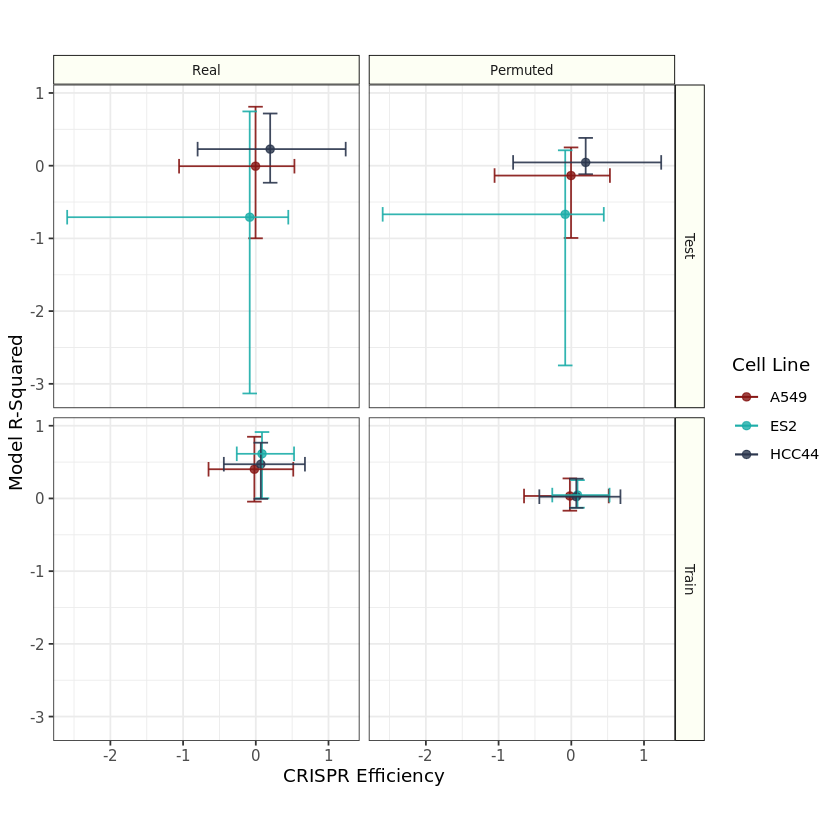

In [11]:
ggplot(summary_df, aes(x = mean_crispr_eff, y = mean_rsquared_diff, color = Metadata_cell_line)) +
    geom_point(size = 2, alpha = 0.8) +
    geom_errorbar(aes(ymin = low_r2err_conf, ymax = high_r2err_conf), alpha = 0.9, width = 0.2) +
    geom_errorbarh(aes(xmin = low_crispr_conf, xmax = high_crispr_conf), alpha = 0.9, height = 0.2) +
    facet_grid(data_type~shuffle) +
    ylab("Model R-Squared") +
    xlab("CRISPR Efficiency") + 
    scale_color_manual(
        name = "Cell Line",
        labels = cell_line_labels,
        values = cell_line_colors
    ) +
    coord_fixed() +
    theme_bw() +
    theme(axis.text = element_text(size = 9),
          axis.title = element_text(size = 11),
          strip.text = element_text(size = 8),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

output_file <- file.path(
    figure_dir,
    paste0("crispr_efficiency_regression_compare_", consensus, ".png")
)
ggsave(output_file, height = 4.5, width = 4.5, dpi = 500)

## Visualize

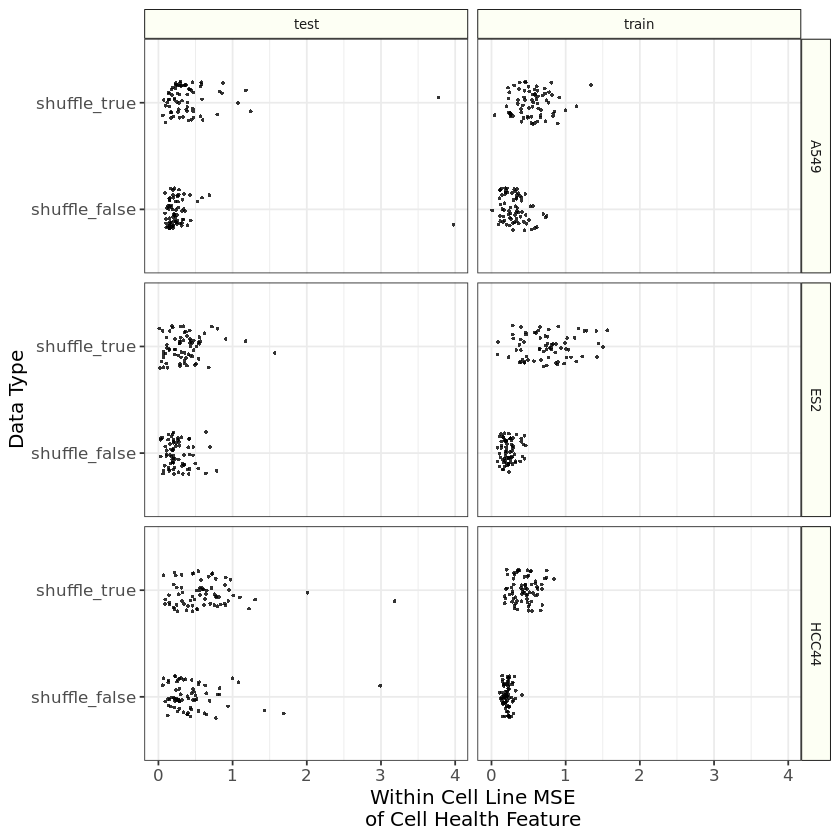

In [12]:
ggplot(regression_metrics_df %>% dplyr::filter(metric == "mse"),
       aes(x = shuffle,
           y = value)) +
    geom_jitter(width = 0.2, size = 0.7, alpha = 0.8, pch = 16) +
    facet_grid(cell_line~data_fit) +
    xlab("Data Type") +
    ylab("Within Cell Line MSE\nof Cell Health Feature") +
    coord_flip() +
    theme_bw() +
    theme(axis.text = element_text(size = 10),
          axis.title = element_text(size = 12),
          strip.text = element_text(size = 8),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

output_file <- file.path(
    figure_dir,
    paste0("cell_line_mse_differences_", consensus, ".png")
)
ggsave(output_file, height = 5, width = 5, dpi = 500)

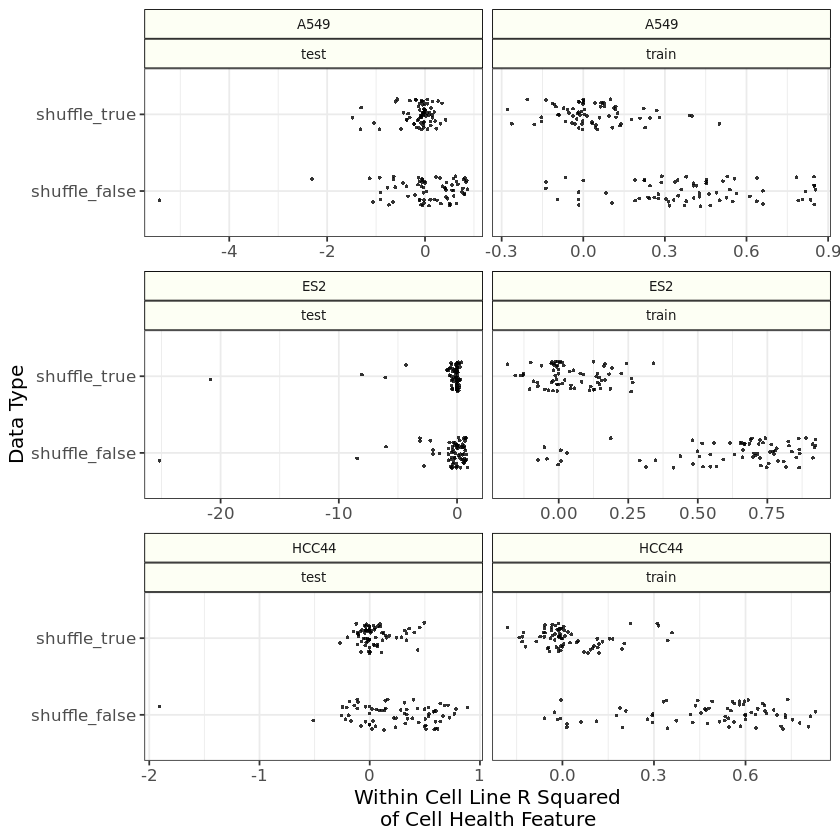

In [13]:
ggplot(regression_metrics_df %>% dplyr::filter(metric == "r_two"),
       aes(x = shuffle,
           y = value)) +
    geom_jitter(width = 0.2, size = 0.7, alpha = 0.8, pch = 16) +
    facet_wrap(cell_line~data_fit, ncol = 2, scales = "free_x") +
    xlab("Data Type") +
    ylab("Within Cell Line R Squared\nof Cell Health Feature") +
    coord_flip() +
    theme_bw() +
    theme(axis.text = element_text(size = 10),
          axis.title = element_text(size = 12),
          strip.text = element_text(size = 8),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

output_file <- file.path(
    figure_dir,
    paste0("cell_line_rsquared_differences_", consensus, ".png")
)
ggsave(output_file, height = 5, width = 5, dpi = 500)

In [14]:
# Compile Results
regression_results_df <- regression_metrics_df %>%
    dplyr::left_join(label_df, by = c("target" = "id")) %>%
    dplyr::mutate(plot_group = paste(metric, target, shuffle))

dim(regression_results_df)
head(regression_results_df, 2)

[1] 1680   23

value,metric,target,data_fit,shuffle,y_transform,cell_line,readable_name,original_name,feature_type,...,hoechst,edu,ph3,gh2ax,caspase,draq7,cell_rox,dpc,description,plot_group
0.6452902,mse,cc_all_high_h2ax,train,shuffle_true,raw,ES2,ALL - % High gH2AX Spots,ALL - High number of spots gH2AX - Mean per Well,cell_cycle,...,1,0,0,1,0,0,0,0,Within all cells: fraction of cells containing more than 3 gH2AX spots,mse cc_all_high_h2ax shuffle_true
0.5121054,mse,cc_all_high_h2ax,test,shuffle_true,raw,ES2,ALL - % High gH2AX Spots,ALL - High number of spots gH2AX - Mean per Well,cell_cycle,...,1,0,0,1,0,0,0,0,Within all cells: fraction of cells containing more than 3 gH2AX spots,mse cc_all_high_h2ax shuffle_true


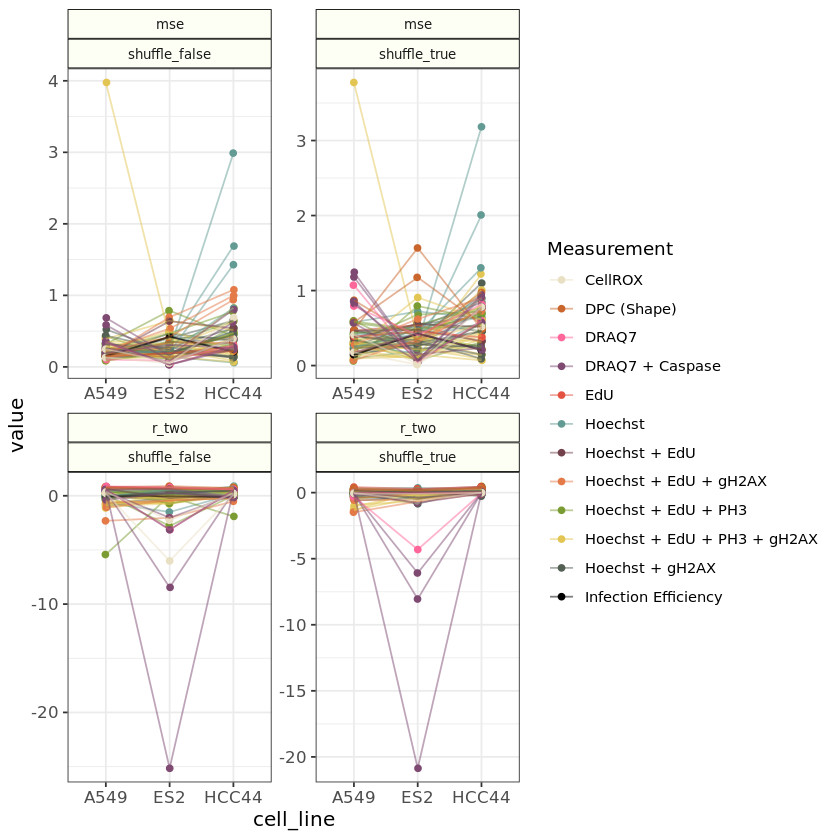

In [15]:
ggplot(regression_results_df %>%
       dplyr::filter(data_fit == "test"),
       aes(x = cell_line,
           y = value,
           group = plot_group)) +
    geom_jitter(aes(color = assay), width = 0.01) +
    geom_line(aes(color = assay),
              alpha = 0.5) +
    scale_color_manual(name = "Measurement",
                       values = dye_colors,
                       labels = dye_labels) +
    facet_wrap(metric~shuffle, scales = "free") +
    theme_bw() +
    theme(axis.text = element_text(size = 10),
          axis.title = element_text(size = 12),
          strip.text = element_text(size = 8),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

output_file <- file.path(
    figure_dir,
    paste0("cell_line_differences_target_linked_full_", consensus, ".png")
)
ggsave(output_file, height = 5, width = 6.5, dpi = 500)

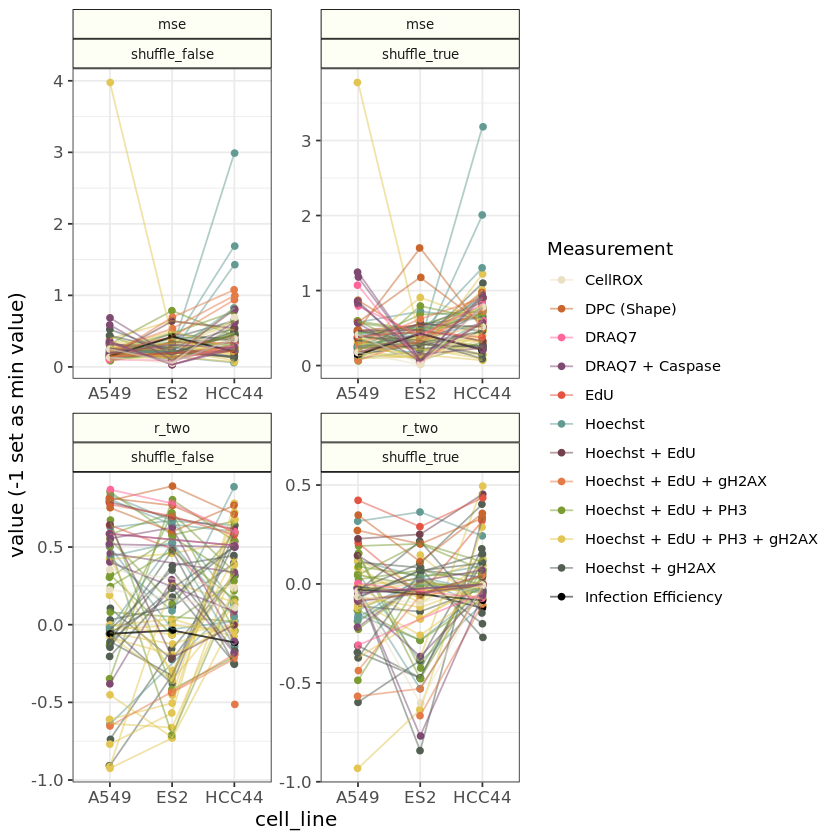

In [16]:
ggplot(regression_results_df %>%
       dplyr::filter(data_fit == "test",
                     value > -1),
       aes(x = cell_line,
           y = value,
           group = plot_group)) +
    geom_jitter(aes(color = assay), width = 0.01) +
    geom_line(aes(color = assay),
              alpha = 0.5) +
    ylab("value (-1 set as min value)") +
    scale_color_manual(name = "Measurement",
                       values = dye_colors,
                       labels = dye_labels) +
    facet_wrap(metric~shuffle, scales = "free") +
    theme_bw() +
    theme(axis.text = element_text(size = 10),
          axis.title = element_text(size = 12),
          strip.text = element_text(size = 8),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

output_file <- file.path(
    figure_dir,
    paste0("cell_line_differences_target_linked_subset_", consensus, ".png")
)
ggsave(output_file, height = 5, width = 6.5, dpi = 500)

## Rank Models

Laslty, we rank models based on test set regression peformance in A549 cells.

In [17]:
spread_regression_results_df <- regression_results_df %>%
    dplyr::filter(
        cell_line == "A549",
        data_fit == "test",
        metric == "r_two"
    ) %>%
    dplyr::select(
        value, metric, shuffle, target, original_name, readable_name,
        feature_type, measurement, assay, description
    ) %>%
    tidyr::spread(shuffle, value) %>%
    dplyr::arrange(desc(shuffle_false))

spread_regression_results_df$target <- factor(
    spread_regression_results_df$target,
    levels = rev(unique(spread_regression_results_df$target))
)
spread_regression_results_df$original_name <- factor(
    spread_regression_results_df$original_name,
    levels = rev(unique(spread_regression_results_df$original_name))
)

# # Output ranked models
# output_file <- file.path(
#     "..",
#     "4.apply",
#     "repurposing_cellhealth_shiny",
#     "data",
#     paste0("A549_ranked_models_regression_", consensus, ".tsv")
# )
# readr::write_tsv(spread_regression_results_df, output_file)

# print(dim(spread_regression_results_df))
# head(spread_regression_results_df, 10)

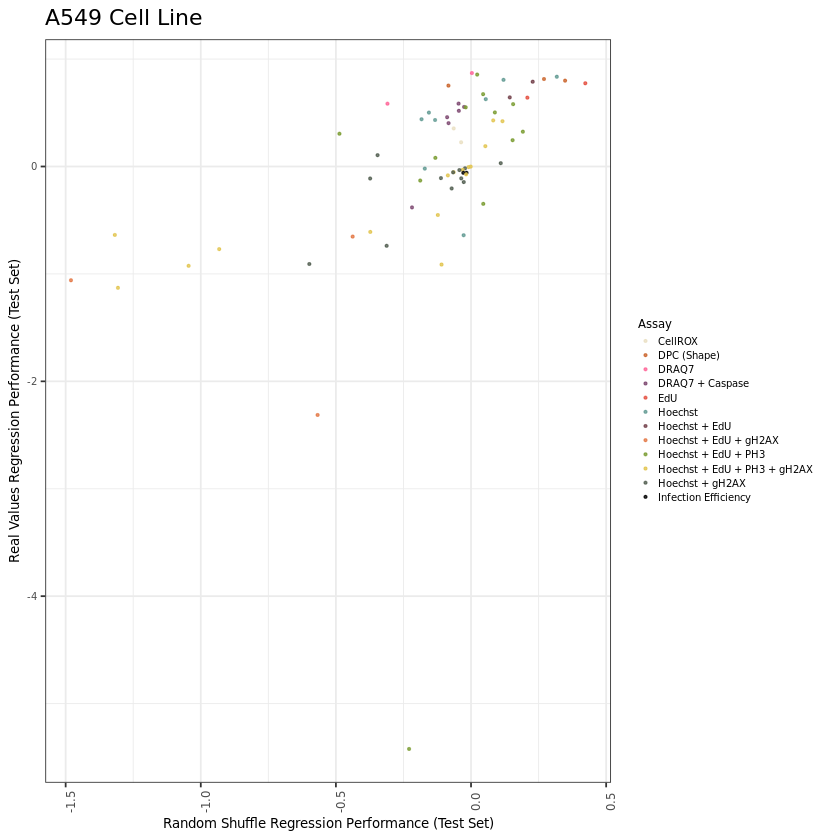

In [18]:
ggplot(spread_regression_results_df, aes(x = shuffle_true, y = shuffle_false)) +
    geom_point(aes(color = assay),
               size = 0.5,
               alpha = 0.8) +
    xlab("Random Shuffle Regression Performance (Test Set)") +
    ylab("Real Values Regression Performance (Test Set)") +
    ggtitle("A549 Cell Line") +
    theme_bw() +
    theme(axis.text.y = element_text(size = 6),
          axis.text.x = element_text(size = 7, angle = 90),
          axis.title = element_text(size = 8),
          legend.title = element_text(size = 7),
          legend.text = element_text(size = 6),
          legend.key.size = unit(0.3, "cm")) +
    scale_color_manual(name = "Assay",
                       values = dye_colors,
                       labels = dye_labels) 

output_file = file.path(
    figure_dir,
    paste0("ranked_models_A549_with_shuffle_", consensus, ".png")
)
ggsave(output_file, dpi = 300, height = 3.5, width = 4)

In [19]:
regression_rank_plot_df <- build_plot_data(
    regression_results_df, cell_line="A549", data_fit="test", metric="r_two"
)

sorted_non_shuffle <- regression_rank_plot_df %>%
    dplyr::filter(shuffle == "shuffle_false") %>%
    dplyr::arrange(desc(value))

target_levels <- rev(
    sorted_non_shuffle %>%
        dplyr::pull(target)
    )

name_levels <- rev(
    sorted_non_shuffle %>%
        dplyr::pull(readable_name)
    )

regression_rank_plot_df$target <- factor(
    regression_rank_plot_df$target, levels = target_levels
)
regression_rank_plot_df$readable_name <- factor(
    regression_rank_plot_df$readable_name,
    levels = name_levels
)

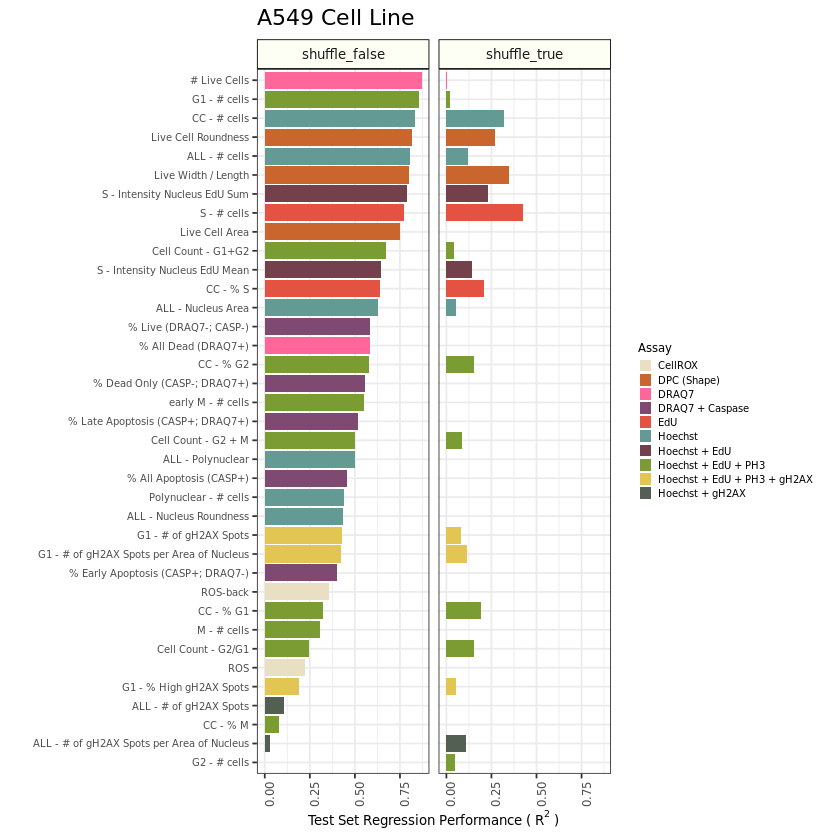

In [20]:
ggplot(regression_rank_plot_df %>%
           dplyr::filter(value > 0),
       aes(x = readable_name, y = value)) +
    geom_bar(aes(fill = assay), stat="identity") +
    ylab(bquote("Test Set Regression Performance ("~R^2~")")) +
    xlab("") +
    ggtitle("A549 Cell Line") +
    coord_flip() +
    theme_bw() +
    facet_wrap(~shuffle, nrow = 1) +
    theme(
        axis.text.y = element_text(size = 6),
        axis.text.x = element_text(size = 7, angle = 90),
        axis.title = element_text(size = 8),
        legend.title = element_text(size = 7),
        strip.text = element_text(size = 8),
        strip.background = element_rect(colour = "black",
                                      fill = "#fdfff4"),
        legend.text = element_text(size = 6),
        legend.key.size = unit(0.3, "cm")
    ) +
    scale_fill_manual(
        name = "Assay",
        values = dye_colors,
        labels = dye_labels
    ) 

output_file = file.path(
    figure_dir,
    paste0("ranked_models_A549_", consensus, ".png")
)
ggsave(output_file, dpi = 300, height = 6, width = 8)

## Determine Classification Performance

In [21]:
roc_file <- file.path(
    results_dir,
    paste0("full_cell_health_roc_results_", consensus, ".tsv.gz")
)
full_roc_df <- readr::read_tsv(roc_file, col_types = readr::cols()) %>%
    dplyr::filter(cell_line %in% cell_lines)

pr_file <- file.path(results_dir,
                     paste0("full_cell_health_pr_results_", consensus, ".tsv.gz"))
full_pr_df <- readr::read_tsv(pr_file, col_types = readr::cols()) %>%
    dplyr::filter(cell_line %in% cell_lines)

auroc_df <- full_roc_df %>%
    dplyr::distinct(metric, target, auc, cell_line, data_fit, shuffle, y_transform, min_class_count)

aupr_df <- full_pr_df %>%
    dplyr::distinct(metric, target, auc, cell_line, data_fit, shuffle, y_transform, min_class_count)

auc_df <- dplyr::bind_rows(auroc_df, aupr_df)

# Replace missing data with zero (for plotting reasons)
auc_df$auc[is.na(auc_df$auc)] <- 0

head(auc_df, 10)

metric,target,auc,cell_line,data_fit,shuffle,y_transform,min_class_count
roc,cc_all_high_h2ax,0.8599034,ES2,train,shuffle_true,binarize,32
roc,cc_all_high_h2ax,0.0000000,ES2,test,shuffle_true,binarize,32
roc,cc_all_high_h2ax,0.6398601,HCC44,train,shuffle_true,binarize,32
roc,cc_all_high_h2ax,0.6875000,HCC44,test,shuffle_true,binarize,32
roc,cc_all_high_h2ax,0.8219780,A549,train,shuffle_true,binarize,32
roc,cc_all_high_h2ax,0.0000000,A549,test,shuffle_true,binarize,32
roc,cc_all_high_h2ax,0.9879227,ES2,train,shuffle_false,binarize,32
roc,cc_all_high_h2ax,0.0000000,ES2,test,shuffle_false,binarize,32
roc,cc_all_high_h2ax,0.9055944,HCC44,train,shuffle_false,binarize,32
roc,cc_all_high_h2ax,0.8125000,HCC44,test,shuffle_false,binarize,32


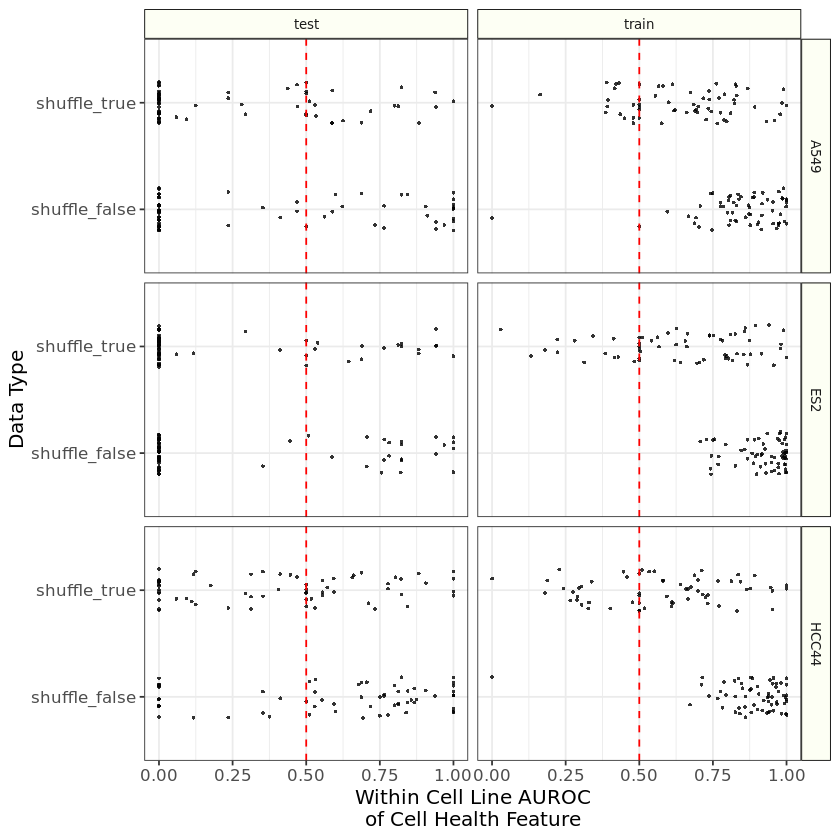

In [22]:
ggplot(auc_df %>% dplyr::filter(metric == "roc"),
       aes(x = shuffle,
           y = auc)) +
    geom_jitter(width = 0.2, size = 0.7, alpha = 0.8, pch = 16) +
    facet_grid(cell_line~data_fit) +
    xlab("Data Type") +
    ylab("Within Cell Line AUROC\nof Cell Health Feature") +
    coord_flip() +
    geom_hline(yintercept = 0.5, linetype = "dashed", color = "red") +
    theme_bw() +
    theme(axis.text = element_text(size = 10),
          axis.title = element_text(size = 12),
          strip.text = element_text(size = 8),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

output_file <- file.path(
    figure_dir,
    paste0("cell_line_roc_differences_", consensus, ".png")
)
ggsave(output_file, height = 5, width = 5, dpi = 500)

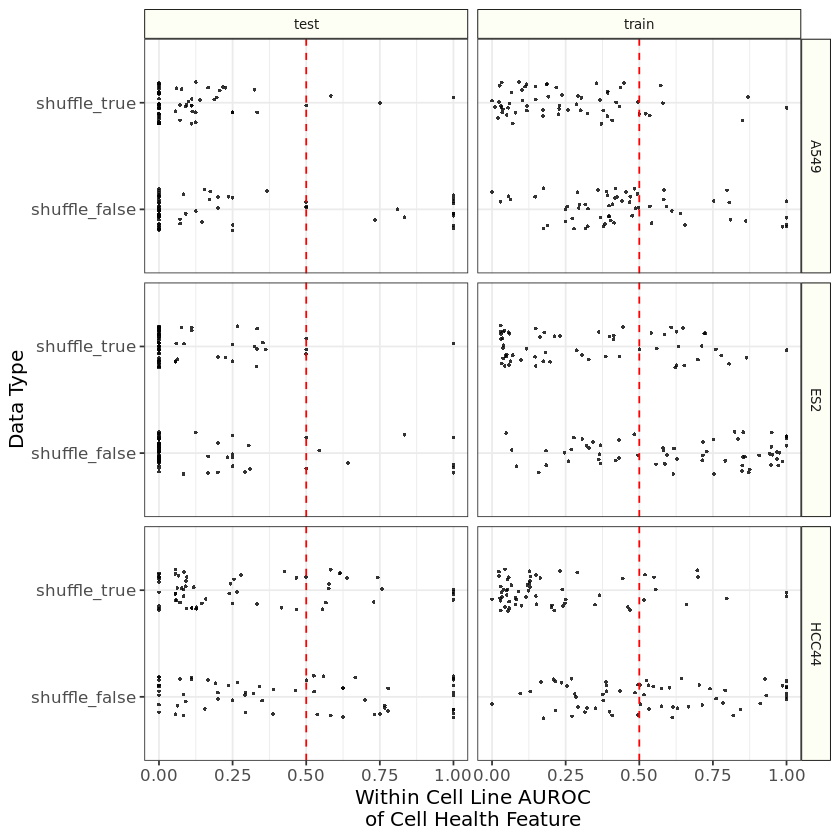

In [23]:
ggplot(auc_df %>% dplyr::filter(metric == "aupr"),
       aes(x = shuffle,
           y = auc)) +
    geom_jitter(width = 0.2, size = 0.7, alpha = 0.8, pch = 16) +
    facet_grid(cell_line~data_fit) +
    xlab("Data Type") +
    ylab("Within Cell Line AUROC\nof Cell Health Feature") +
    coord_flip() +
    geom_hline(yintercept = 0.5, linetype = "dashed", color = "red") +
    theme_bw() +
    theme(axis.text = element_text(size = 10),
          axis.title = element_text(size = 12),
          strip.text = element_text(size = 8),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

output_file <- file.path(
    figure_dir,
    paste0("cell_line_pr_differences_", consensus, ".png")
)
ggsave(output_file, height = 5, width = 5, dpi = 500)

In [24]:
# Compile Results
classification_results_df <- auc_df %>%
    dplyr::left_join(label_df, by = c("target" = "id")) %>%
    dplyr::mutate(plot_group = paste(metric, target, shuffle))

dim(classification_results_df)
head(classification_results_df, 2)

[1] 1488   24

metric,target,auc,cell_line,data_fit,shuffle,y_transform,min_class_count,readable_name,original_name,...,hoechst,edu,ph3,gh2ax,caspase,draq7,cell_rox,dpc,description,plot_group
roc,cc_all_high_h2ax,0.8599034,ES2,train,shuffle_true,binarize,32,ALL - % High gH2AX Spots,ALL - High number of spots gH2AX - Mean per Well,...,1,0,0,1,0,0,0,0,Within all cells: fraction of cells containing more than 3 gH2AX spots,roc cc_all_high_h2ax shuffle_true
roc,cc_all_high_h2ax,0.0000000,ES2,test,shuffle_true,binarize,32,ALL - % High gH2AX Spots,ALL - High number of spots gH2AX - Mean per Well,...,1,0,0,1,0,0,0,0,Within all cells: fraction of cells containing more than 3 gH2AX spots,roc cc_all_high_h2ax shuffle_true


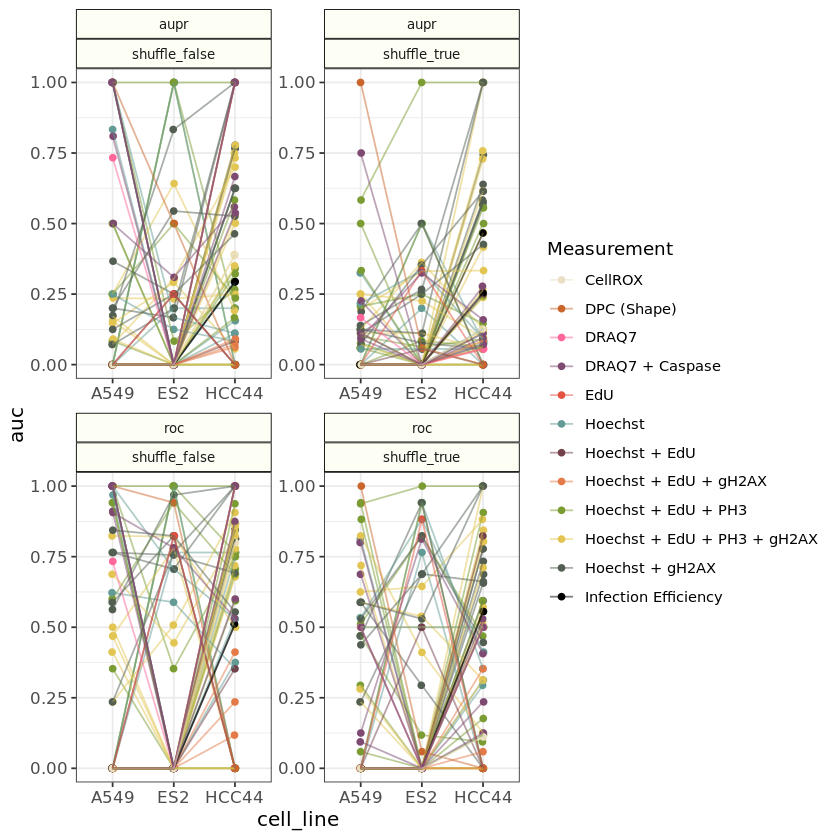

In [25]:
ggplot(classification_results_df %>%
           dplyr::filter(data_fit == "test"),
       aes(x = cell_line,
           y = auc,
           group = plot_group)) +
    geom_jitter(aes(color = assay), width = 0.01) +
    geom_line(aes(color = assay),
              alpha = 0.5) +
    scale_color_manual(name = "Measurement",
                       values = dye_colors,
                       labels = dye_labels) +
    facet_wrap(metric~shuffle, scales = "free") +
    theme_bw() +
    theme(axis.text = element_text(size = 10),
          axis.title = element_text(size = 12),
          strip.text = element_text(size = 8),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

output_file <- file.path(
    figure_dir,
    paste0("cell_line_differences_classification_target_linked_full_", consensus, ".png")
)
ggsave(output_file, height = 5, width = 6.5, dpi = 500)

## Rank Models based on A549 Performance

In [26]:
spread_classification_results_df <- classification_results_df %>%
    dplyr::filter(
        cell_line == "A549",
        data_fit == "test",
        metric == "aupr"
    ) %>%
    dplyr::select(
        auc, metric, shuffle, target, original_name, readable_name,
        feature_type, measurement, assay, description
    ) %>%
    tidyr::spread(shuffle, auc) %>%
    dplyr::arrange(desc(shuffle_false))

spread_classification_results_df$target <- factor(
    spread_classification_results_df$target,
    levels = rev(unique(spread_classification_results_df$target))
)
spread_classification_results_df$original_name <- factor(
    spread_classification_results_df$original_name,
    levels = rev(unique(spread_classification_results_df$original_name))
)

In [27]:
# # Output ranked models
# output_file <- file.path(
#     "..",
#     "4.apply",
#     "repurposing_cellhealth_shiny",
#     "data",
#     paste0("A549_ranked_models_classification_", consensus, ".tsv")
# )
# readr::write_tsv(spread_classification_results_df, output_file)

# print(dim(spread_classification_results_df))
# head(spread_classification_results_df, 10)

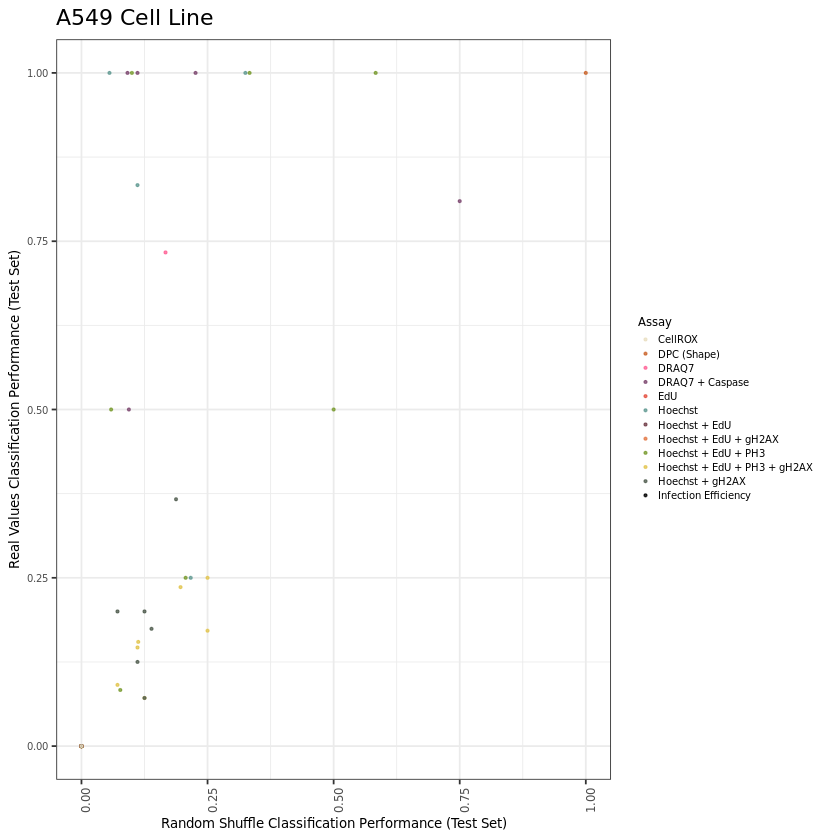

In [28]:
ggplot(spread_classification_results_df, aes(x = shuffle_true, y = shuffle_false)) +
    geom_point(aes(color = assay),
               size = 0.5,
               alpha = 0.8) +
    xlab("Random Shuffle Classification Performance (Test Set)") +
    ylab("Real Values Classification Performance (Test Set)") +
    ggtitle("A549 Cell Line") +
    theme_bw() +
    theme(axis.text.y = element_text(size = 6),
          axis.text.x = element_text(size = 7, angle = 90),
          axis.title = element_text(size = 8),
          legend.title = element_text(size = 7),
          legend.text = element_text(size = 6),
          legend.key.size = unit(0.3, "cm")) +
    scale_color_manual(name = "Assay",
                       values = dye_colors,
                       labels = dye_labels) 

output_file = file.path(
    figure_dir,
    paste0("ranked_models_A549_with_shuffle_classification_", consensus, ".png")
)
ggsave(output_file, dpi = 300, height = 3.5, width = 4)

In [29]:
classification_rank_plot_df <- build_plot_data(
    classification_results_df, cell_line="A549", data_fit="test", metric="aupr", results_type="classification"
)

sorted_non_shuffle <- classification_rank_plot_df %>%
    dplyr::filter(shuffle == "shuffle_false") %>%
    dplyr::arrange(desc(auc))

target_levels <- rev(
    sorted_non_shuffle %>%
        dplyr::pull(target)
    )

name_levels <- rev(
    sorted_non_shuffle %>%
        dplyr::pull(readable_name)
    )

classification_rank_plot_df$target <- factor(
    classification_rank_plot_df$target, levels = target_levels
)
classification_rank_plot_df$readable_name <- factor(
    classification_rank_plot_df$readable_name,
    levels = name_levels
)

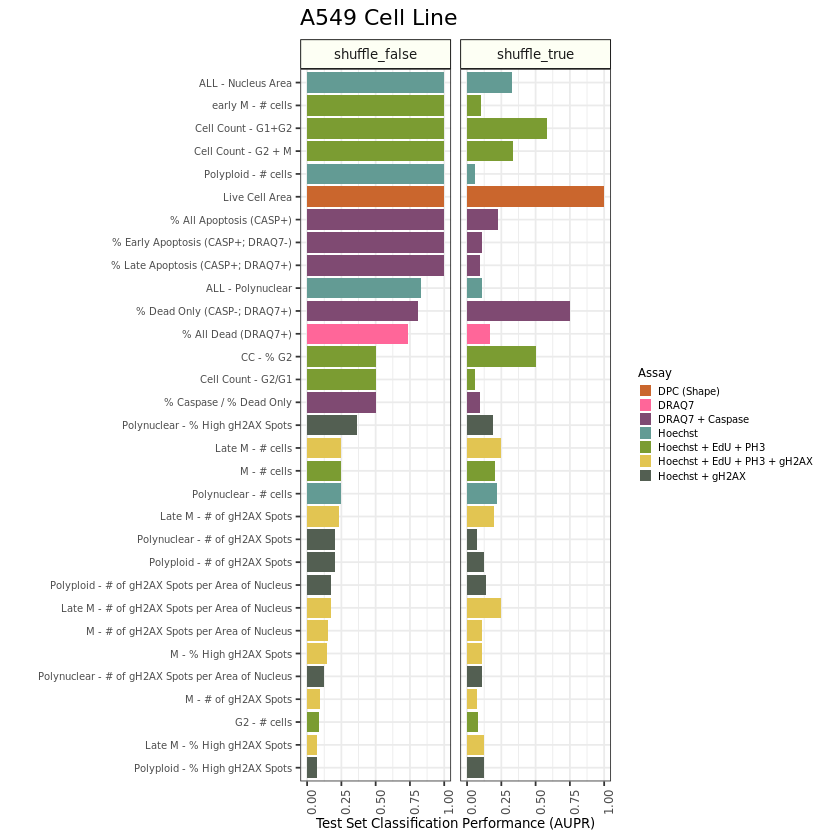

In [30]:
ggplot(classification_rank_plot_df %>% dplyr::filter(auc > 0),
       aes(x = readable_name, y = auc)) +
    geom_bar(aes(fill = assay), stat="identity") +
    ylab("Test Set Classification Performance (AUPR)") +
    xlab("") +
    ggtitle("A549 Cell Line") +
    coord_flip() +
    ylim(c(0, 1)) +
    facet_wrap(~shuffle, nrow = 1) +
    theme_bw() +
    theme(
        axis.text.y = element_text(size = 6),
        axis.text.x = element_text(size = 7, angle = 90),
        axis.title = element_text(size = 8),
        legend.title = element_text(size = 7),
        legend.text = element_text(size = 6),
        legend.key.size = unit(0.3, "cm"),
        strip.text = element_text(size = 8),
        strip.background = element_rect(colour = "black",
                                        fill = "#fdfff4")
    ) +
    scale_fill_manual(
        name = "Assay",
        values = dye_colors,
        labels = dye_labels
    )

output_file = file.path(
    figure_dir,
    paste0("ranked_models_A549_", consensus, "_classification.png")
)
ggsave(output_file, dpi = 300, height = 6, width = 8)